<a href="https://colab.research.google.com/github/Dimitri78000/Neural_network_saliency/blob/master/Keras_saillancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Find visual saliency in uncompressed videos 

Dimitri LEURS and Khalil GHETARI framed by mihai MITREA
 
 Engineering school : Télécom SudParis

[Keras doc](https://keras.io/)

In [1]:
!pip install -q pyyaml
!pip install -U -q PyDrive

import os
import tensorflow as tf
mnist = tf.keras.datasets.mnist
from tensorflow.keras import layers
from google.colab import files
from google.colab import auth

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

np.random.seed(77)
import random as rd


    100% |████████████████████████████████| 993kB 1.6MB/s 


In [0]:
# Récupérer la base de donnée original, avec  des images de taille 720x576
# Durée : 

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('/content')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1uR1sdAginFViKKdY2ndl2JlLDbv4DBzk' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
 

title: v7_x26.jpg, id: 1D96vOjd5lPLjNGRmL2S8E6yfYDCYEvsI
downloading to /content/v7_x26.jpg
title: v7_x30.jpg, id: 1KnOvoo5zpEDXS2u6ziT3dmolH05v9CB7
downloading to /content/v7_x30.jpg
title: v7_x22.jpg, id: 1ZqL3BtDNG987fHHmdfvvL4hKSvDtT_j5
downloading to /content/v7_x22.jpg
title: v7_x28.jpg, id: 1_x7irsHv4plwkwkdTKVLgAVtfSIoWXkR
downloading to /content/v7_x28.jpg
title: v7_x24.jpg, id: 1V6dvooAvclXmJi9RV5LGAokSj0lpPTdB
downloading to /content/v7_x24.jpg
title: v7_x23.jpg, id: 1bd8oN20idnZnFx9IOhVMRw48SsKDIQ6p
downloading to /content/v7_x23.jpg
title: v7_x27.jpg, id: 1ITnB860dhhDeiEgKEugOKC56y-HprN-R
downloading to /content/v7_x27.jpg
title: v7_x25.jpg, id: 1YSs9YMYMxjzbZ5qlGkTxCIrbJ8LtgcRY
downloading to /content/v7_x25.jpg
title: v7_x21.jpg, id: 1g91D0TcIQgTmTSksudU_HKbp7on7g3Da
downloading to /content/v7_x21.jpg
title: v7_x17.jpg, id: 12r2XZg678LEKc8MNPnRXnOOmHQAyfZtA
downloading to /content/v7_x17.jpg
title: v7_x15.jpg, id: 1_hrwQlluLnE8Di9MoGsEVDzV7reBCtIi
downloading to /content

In [0]:
def resize_picture(img, nb):
  scale_percent = 80
  width = int(img.shape[1] / nb)
  height = int(img.shape[0] / nb)
  dim = (width, height)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

def make_img_one_and_zero(img, seuil):
  max = img[0][0]
  for i in range (0, img.shape[0]):
    for j in range(0, img.shape[1]):
      if (img[i][j] > max):
        max = img[i][j]
  for i in range (0, img.shape[0]):
    for j in range(0, img.shape[1]):
      if (img[i][j] < max / seuil):
        img[i][j] = 0
      else:
        img[i][j] = 1
        
def float_to_int(img):
  for i in range (0, img.shape[0]):
    for j in range(0, img.shape[1]):
      if (img[i][j] >= 8):
        img[i][j] = 1
      else:
        img[i][j] = 0
        

In [0]:
dictionnary_image = {}

for i in range (1, 7+1):
  for j in range (1, 30+1):
    dictionnary_image["v" +str(i)+"_c"+str(j)] = np.array(cv2.imread("v"+str(i)+"_c"+str(j)+".jpg",0))
    dictionnary_image["v" +str(i)+"_i"+str(j)] = np.array(cv2.imread("v"+str(i)+"_i"+str(j)+".jpg",0))
    dictionnary_image["v" +str(i)+"_m"+str(j)] = np.array(cv2.imread("v"+str(i)+"_m"+str(j)+".jpg",0))
    dictionnary_image["v" +str(i)+"_o"+str(j)] = np.array(cv2.imread("v"+str(i)+"_o"+str(j)+".jpg",0))
    dictionnary_image["v" +str(i)+"_x"+str(j)] = np.array(cv2.imread("v"+str(i)+"_x"+str(j)+".jpg",0))
    
# 720 = 2 × 2 × 2 × 2 × 3 × 3 × 5
# 576 = 2 × 2 × 2 × 2 × 2 × 2 × 3 × 3
# 36 (= 2x2x3x3) et 144 (= 2x2x2x2x3x3) sont donc des diviseurs communs 

for i in range (1, 7+1):
  for j in range (1, 30+1):
    dictionnary_image["rv" +str(i)+"_c"+str(j)] = resize_picture(np.array(cv2.imread("v"+str(i)+"_c"+str(j)+".jpg",0)),36)
    dictionnary_image["rv" +str(i)+"_i"+str(j)] = resize_picture(np.array(cv2.imread("v"+str(i)+"_i"+str(j)+".jpg",0)),36)
    dictionnary_image["rv" +str(i)+"_m"+str(j)] = resize_picture(np.array(cv2.imread("v"+str(i)+"_m"+str(j)+".jpg",0)),36)
    dictionnary_image["rv" +str(i)+"_o"+str(j)] = resize_picture(np.array(cv2.imread("v"+str(i)+"_o"+str(j)+".jpg",0)),36)
    dictionnary_image["rv" +str(i)+"_x"+str(j)] = resize_picture(np.array(cv2.imread("v"+str(i)+"_x"+str(j)+".jpg",0)),144)
    make_img_one_and_zero(dictionnary_image["rv" +str(i)+"_x"+str(j)], 5)

In [0]:
# Save the resized file
"""
for i in range (1, 7+1):
  for j in range (1, 30+1):
    cv2.imwrite( "resized_picture/rv" +str(i)+"_c"+str(j), dictionnary_image["rv" +str(i)+"_c"+str(j)] );
    cv2.imwrite( "resized_picture/rv" +str(i)+"_i"+str(j), dictionnary_image["rv" +str(i)+"_i"+str(j)] );
    cv2.imwrite( "resized_picture/rv" +str(i)+"_m"+str(j), dictionnary_image["rv" +str(i)+"_m"+str(j)] );
    cv2.imwrite( "resized_picture/rv" +str(i)+"_o"+str(j), dictionnary_image["rv" +str(i)+"_o"+str(j)] );
    cv2.imwrite( "resized_picture/rv" +str(i)+"_x"+str(j), dictionnary_image["rv" +str(i)+"_x"+str(j)] );
"""

Shape of v1_c1 :  (576, 720)
Shape of rv1_c1 :  (16, 20)
Shape of v1_x1 :  (576, 720)
Shape of rv1_xc1 :  (4, 5)


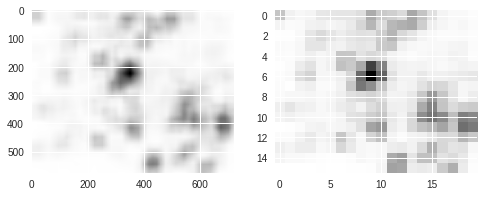

In [0]:
print("Shape of v1_c1 : ", dictionnary_image["v1_c1"].shape)
print("Shape of rv1_c1 : ",dictionnary_image["rv1_c1"].shape)
print("Shape of v1_x1 : ",dictionnary_image["v1_x1"].shape)
print("Shape of rv1_xc1 : ",dictionnary_image["rv1_x1"].shape)


imgLr = dictionnary_image["v1_c1"]
imgRr = dictionnary_image["rv1_c1"]

#imgLr = dictionnary_image["v5_x27"]
#imgRr = dictionnary_image["rv5_x27"]

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(imgLr)
f.add_subplot(1,2, 2)
plt.imshow(imgRr)
plt.show(block=True)

Before manipulation
X_train.shape : (189, 64, 20)
Y_train.shape : (189, 4, 5) 

X_test.shape : (21, 64, 20)
Y_test.shape : (21, 4, 5)


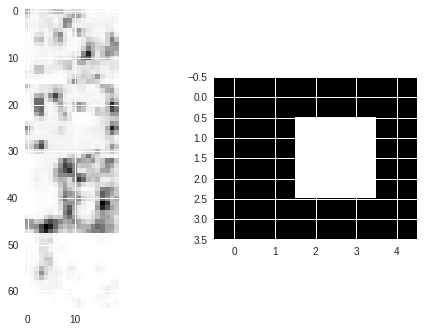

After manipulation
X_train.shape : (189, 1280)
Y_train.shape : (189, 20) 

X_test.shape : (21, 1280)
y_test.shape : (21, 20)


In [0]:
X_train = np.empty((189,64,20)) # 189 = 27 (we took 27 images out of 30 for testing) * 7 (7 videos) , 64 = 16 * 20 (reduced image size) * 4 (i + c + m + o)
Y_train = np.empty((189,4,5)) # 4 , 5 (resized eye tracker shape)

X_test = np.empty((21,64,20)) # 21 = 4 * 7
Y_test = np.empty((21,4,5)) 

shuffle_index_train = np.linspace(start=0, stop=188, num = 189, dtype=int)
np.random.shuffle(shuffle_index_train)
k = 0
for i in range (1, 7+1):
  for j in range (1, 27+1):
    dictionnary_image["tensor_train_in_"+ str(k)] = np.concatenate((dictionnary_image["rv" +str(i)+"_c"+str(j)] , dictionnary_image["rv" +str(i)+"_i"+str(j)],dictionnary_image["rv" +str(i)+"_m"+str(j)],dictionnary_image["rv" +str(i)+"_o"+str(j)]), axis = 0)
    dictionnary_image["tensor_train_out_"+ str(k)] = dictionnary_image["rv"+str(i)+"_x"+str(j)]
    X_train[shuffle_index_train[k]] = dictionnary_image["tensor_train_in_" + str(k)]
    Y_train[shuffle_index_train[k]] = dictionnary_image["tensor_train_out_" + str(k)]
    k+=1

shuffle_index_test = np.linspace(start=0, stop=20, num = 21, dtype=int)
np.random.shuffle(shuffle_index_test)
k = 0
for i in range (1, 7+1):
  for j in range (28, 30+1):
    dictionnary_image["tensor_test_in_"+ str(k)] = np.concatenate((dictionnary_image["rv" +str(i)+"_c"+str(j)] , dictionnary_image["rv" +str(i)+"_i"+str(j)],dictionnary_image["rv" +str(i)+"_m"+str(j)],dictionnary_image["rv" +str(i)+"_o"+str(j)]), axis = 0)
    dictionnary_image["tensor_test_out_"+ str(k)] = dictionnary_image["rv"+str(i)+"_x"+str(j)]
    X_test[shuffle_index_test[k]] = dictionnary_image["tensor_test_in_"+str(k)]
    Y_test[shuffle_index_test[k]] = dictionnary_image["tensor_test_out_" + str(k)]
    k+=1


print("Before manipulation")
print("X_train.shape :",X_train.shape)
print("Y_train.shape :",Y_train.shape, "\n")
print("X_test.shape :",X_test.shape)
print("Y_test.shape :",Y_test.shape)


f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(X_train[0])
f.add_subplot(1,2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show(block=True)

num_pixels_X = X_train.shape[1] * X_train.shape[2]
num_pixels_Y = Y_train.shape[1] * Y_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], num_pixels_X).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels_X).astype('float32')
Y_train = Y_train.reshape(Y_train.shape[0], num_pixels_Y).astype('float32')
Y_test = Y_test.reshape(Y_test.shape[0], num_pixels_Y).astype('float32')


X_train = X_train / 255
X_test = X_test / 255

print("After manipulation")
print("X_train.shape :",X_train.shape)
print("Y_train.shape :",Y_train.shape, "\n")
print("X_test.shape :",X_test.shape)
print("y_test.shape :",Y_test.shape)

In [0]:

model = tf.keras.Sequential()
print(num_pixels_X,num_pixels_Y)
model.add(layers.Dense(1280, input_dim = num_pixels_X ,activation='relu'))

model.add(layers.Dense(500, activation='relu'))

model.add(layers.Dense(num_pixels_Y, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


"""

def baseline_model():
	# create model
	model = tf.keras.Sequential()
	model.add(layers.Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model



model = baseline_model()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nBaseline Error: %.2f%%" % (100-scores[1]*100))
"""




1280 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 1280)              1639680   
_________________________________________________________________
dense_81 (Dense)             (None, 500)               640500    
_________________________________________________________________
dense_82 (Dense)             (None, 20)                10020     
Total params: 2,290,200
Trainable params: 2,290,200
Non-trainable params: 0
_________________________________________________________________


'\n\ndef baseline_model():\n\t# create model\n\tmodel = tf.keras.Sequential()\n\tmodel.add(layers.Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation=\'relu\'))\n\tmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\tmodel.add(Dropout(0.2))\n\tmodel.add(Flatten())\n\tmodel.add(Dense(128, activation=\'relu\'))\n\tmodel.add(Dense(num_classes, activation=\'softmax\'))\n\t# Compile model\n\tmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n\treturn model\n\n\n\nmodel = baseline_model()\n\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n\nmodel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)\nscores = model.evaluate(X_test, y_test, verbose=0)\nprint("\nBaseline Error: %.2f%%" % (100-scores[1]*100))\n'

In [0]:
"""
def baseline_model():
	# create model
	model = tf.keras.Sequential()
	model.add(layers.Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

model = baseline_model()
"""

In [0]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, batch_size=20, verbose=2)
scores = model.evaluate(X_test, Y_test, verbose=0)
print("\nBaseline Error: %.2f%%" % (100-scores[1]*100))

Train on 189 samples, validate on 21 samples
Epoch 1/40
 - 1s - loss: 0.3384 - acc: 0.8534 - val_loss: 0.3372 - val_acc: 0.8786
Epoch 2/40
 - 0s - loss: 0.2308 - acc: 0.9130 - val_loss: 0.3075 - val_acc: 0.9024
Epoch 3/40
 - 0s - loss: 0.2004 - acc: 0.9177 - val_loss: 0.3006 - val_acc: 0.8833
Epoch 4/40
 - 0s - loss: 0.1721 - acc: 0.9254 - val_loss: 0.2675 - val_acc: 0.9000
Epoch 5/40
 - 0s - loss: 0.1562 - acc: 0.9302 - val_loss: 0.2771 - val_acc: 0.8929
Epoch 6/40
 - 0s - loss: 0.1398 - acc: 0.9407 - val_loss: 0.3331 - val_acc: 0.8786
Epoch 7/40
 - 0s - loss: 0.1525 - acc: 0.9344 - val_loss: 0.3019 - val_acc: 0.8786
Epoch 8/40
 - 0s - loss: 0.1318 - acc: 0.9413 - val_loss: 0.2745 - val_acc: 0.9024
Epoch 9/40
 - 0s - loss: 0.1196 - acc: 0.9481 - val_loss: 0.3029 - val_acc: 0.8929
Epoch 10/40
 - 0s - loss: 0.1065 - acc: 0.9585 - val_loss: 0.3032 - val_acc: 0.8833
Epoch 11/40
 - 0s - loss: 0.0972 - acc: 0.9627 - val_loss: 0.3129 - val_acc: 0.8881
Epoch 12/40
 - 0s - loss: 0.0935 - acc: 

In [0]:
predictions = model.predict(X_test)
print(predictions.shape)
print(Y_test.shape)
predictions = predictions.reshape(predictions.shape[0], 4, 5)
print(predictions.shape)
Y_test = Y_test.reshape(Y_test.shape[0], 4, 5)

for i in range (1, 21):
  print("The prediction :")
  print(predictions[i].astype('int'))
  print("The ground truth :")
  print(Y_test[i], "\n\n")

(21, 20)
(21, 20)
(21, 4, 5)
The prediction :
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
The ground truth :
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]] 


The prediction :
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
The ground truth :
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]] 


The prediction :
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
The ground truth :
[[0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]] 


The prediction :
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
The ground truth :
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]] 


The prediction :
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
The ground truth :
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]] 


The prediction :
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
The ground truth :
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0